In [1]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.ticker as tck
from scipy import integrate
import os
import scipy as sp

In [2]:
def absFFT(times, amplitude):
    """ Calculate the fourier transform of the data. """
    fourierTransform = np.fft.fft(amplitude) / len(amplitude)
    fourierTransform = fourierTransform[range(int(len(amplitude)/2))]
    
    tpCount = len(amplitude)
    values = np.arange(int(tpCount/2))
    timePeriod = tpCount * (times[1] - times[0])
    frequencies = values / timePeriod
    return frequencies, abs(fourierTransform)

In [3]:
def integrate_fft(freq_array, power_array, cutoff_freq):
    """ Numerically integrate power density over frequency from 0 to the cutoff_freq. """
    mask = (freq_array[:] <= cutoff_freq)
    sub_freq_array, sub_power_array = freq_array[mask], power_array[mask]
    area = integrate.simps(sub_power_array, sub_freq_array)
    return area

In [4]:
def get_power_density_spectrum(data, sample_freq=3000):
    """ Calculate the power density spectrum using scipy.signal.periodiogram function. """
    freq, power = sp.signal.periodogram(data, sample_freq, scaling='density')
    return freq, power

In [16]:
def load_data(file_pair, title, channel):
    """ Load csv files in pair and return time and data arrays. """
    file1, file2 = file_pair
    df1 = pd.read_csv(file1, delimiter=',', skiprows=7) #pid 7 #digital filter 11
    times1 = np.array(df1.iloc[:,0])
    data1 = np.array(df1.iloc[:, channel])
    
    
    df2 = pd.read_csv(file2, delimiter=',', skiprows=7) #pid 7 #digital filter 11
    times2 = np.array(df2.iloc[:,0])
    data2 = np.array(df2.iloc[:, channel])
    #data2 = np.array(df2.iloc[:, 2]) # for magnetic field drift 10s

    return times1, data1, times2, data2

# PID Feedback

In [6]:
# filepaths
csv_pair = [r"C:\Users\wuhai\Downloads\PI_Drift_new_params_off.csv", 
            r"C:\Users\wuhai\Downloads\PI_Drift_new_params_on.csv"]

times1, data1, times2, data2 = load_data(csv_pair, 'PID Feedback', 1)

# calculate data means and stds
data_1_mean, data_1_std = np.mean(data1), np.std(data1)
data_2_mean, data_2_std = np.mean(data2), np.std(data2)

# obtain frequency and power density arrays
freq_1, power_1 = get_power_density_spectrum(data1)
freq_2, power_2 = get_power_density_spectrum(data2)

# Obtain area ratios
cutoff_f = 300
area_1, area_2 = integrate_fft(freq_1, power_1, cutoff_f), integrate_fft(freq_2, power_2, cutoff_f)
print(area_1/area_2)

# convert power density into dB
power_1 = 10 * np.log10(power_1)
power_2 = 10 * np.log10(power_2)

163.0430771203308


Mean: 3.0541 $\pm$ 0.0039 G
Mean: 2.9997 $\pm$ 0.0008 G


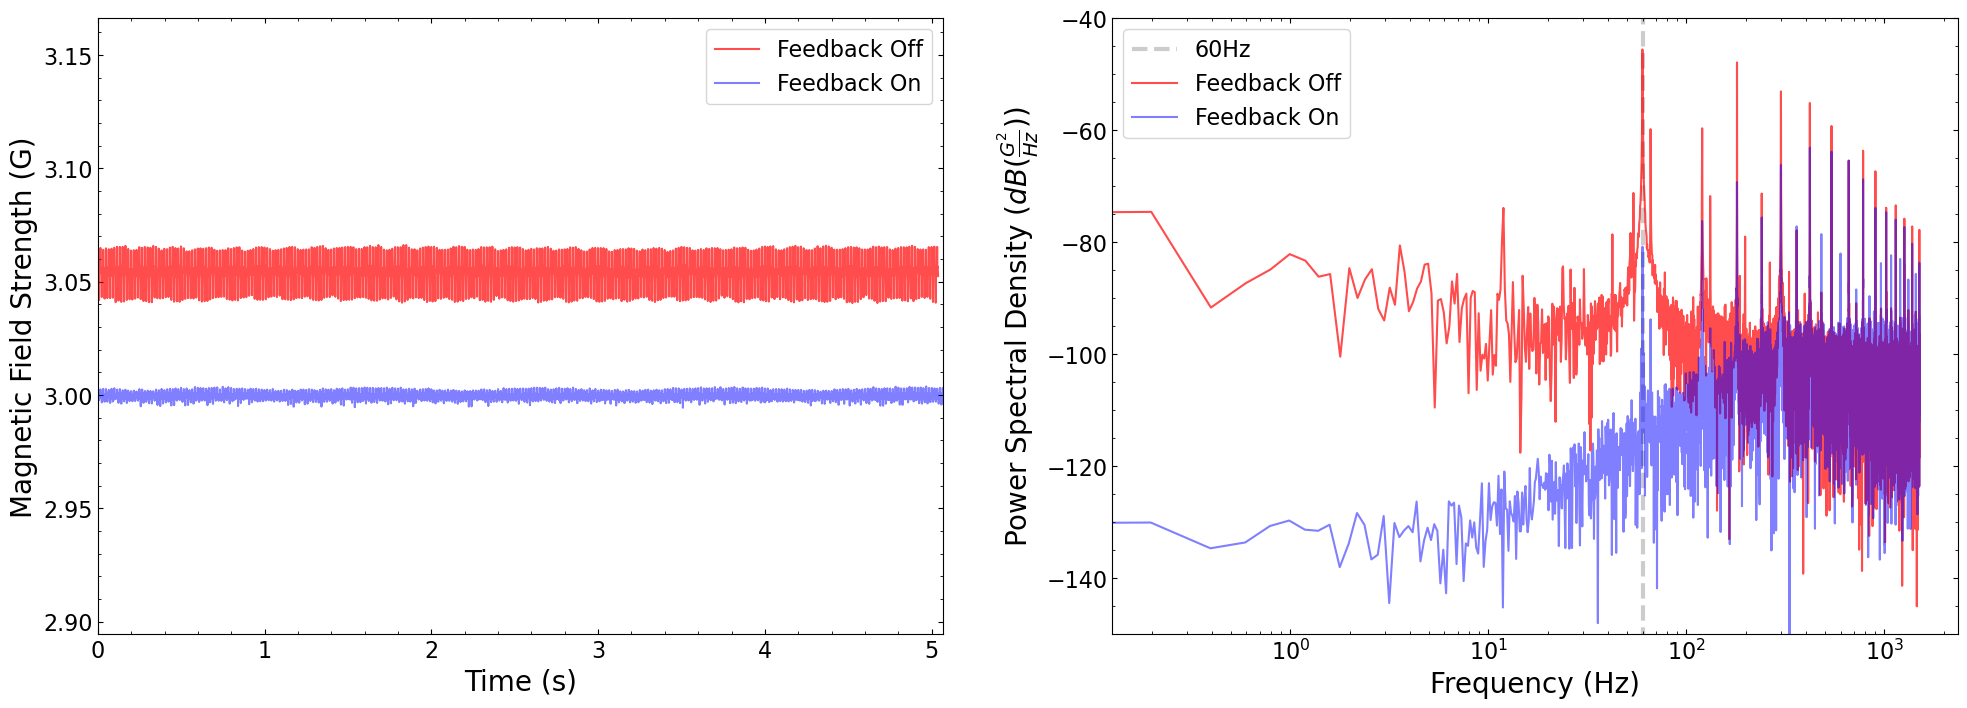

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(24, 8))

# Print data means and stds
data1_text = r'Mean: {:.4f} $\pm$ {:.4f} G'.format(data_1_mean, data_1_std)
data2_text = r'Mean: {:.4f} $\pm$ {:.4f} G'.format(data_2_mean, data_2_std)
print(data1_text)
print(data2_text)

ax[0].plot(times1, data1, label=f'Feedback Off', c='red', alpha=0.7)
ax[0].plot(times2, data2, label=f'Feedback On', c='blue', alpha=0.5)

ax[1].vlines(60, -2000, 0, 'black', linestyle='--', lw=3, label=f'60Hz', alpha=0.2)
ax[1].plot(freq_1, power_1, label='Feedback Off', c='red', alpha=0.7)
ax[1].plot(freq_2, power_2, label='Feedback On', c='blue', alpha=0.5)

title = 'Feedback'
#plt.suptitle(title, fontsize=20, y=0.95) 

# Setting figure display ranges
time_min, time_max = np.min([np.min(times1), np.min(times2)]), np.max([np.max(times1), np.max(times2)])
data1_min, data1_max = np.min([np.min(data1), np.min(data2)]), np.max([np.max(data1), np.max(data2)])
ax[0].set(ylim=(data1_min-0.1, data1_max+0.1))

ax[0].legend(loc='upper right', fontsize=16)
ax[0].set(xlabel='Time (s)', ylabel='Magnetic Field Strength (G)', xlim=(time_min, time_max))

# Setting desired tick paramameters
ax[0].tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=16)
ax[0].xaxis.set_minor_locator(tck.AutoMinorLocator())
ax[0].yaxis.set_minor_locator(tck.AutoMinorLocator())
ax[0].xaxis.label.set_size(20)
ax[0].yaxis.label.set_size(20)

for i in [1]:
    ax[i].legend(loc='upper left', fontsize=16)
    ax[i].tick_params(axis='both', which='both', direction='in',
                      top=True, right=True, labelsize=16)
    ax[i].xaxis.set_minor_locator(tck.AutoMinorLocator())
    ax[i].yaxis.set_minor_locator(tck.AutoMinorLocator())
    ax[i].xaxis.label.set_size(20)
    ax[i].yaxis.label.set_size(20)
    
# Setting label and log scale
ax[1].set_xscale('log')
ax[1].set(xlabel='Frequency (Hz)')
ax[i].set(ylabel=r'Power Spectral Density ($dB(\frac{G^{2}}{Hz}$))', ylim=(-150, -40))

# Save figure to designated filepath
save_path = r"C:\Users\wuhai\AMFS_figs\\" + title + '.png'
#plt.savefig(save_path, dpi=300)

# Mains Electricity Feedforward

In [8]:
# filepaths
csv_pair = [r"C:\Users\wuhai\Downloads\PI_off_Feedforward_off_10s.csv",
            r"C:\Users\wuhai\Downloads\PI_off_Feedforward_on_10s.csv"]
times1, data1, times2, data2 = load_data(csv_pair, 'Feedforward', 2)

# calculate data means and stds
cutoff_f = 60
data_1_mean, data_1_std = np.mean(data1), np.std(data1)
data_2_mean, data_2_std = np.mean(data2), np.std(data2)

# obtain frequency and power density arrays
freq_1, power_1 = get_power_density_spectrum(data1)
freq_2, power_2 = get_power_density_spectrum(data2)

# Obtain area ratios
cutoff_f = 3000
area_1, area_2 = integrate_fft(freq_1, power_1, cutoff_f), integrate_fft(freq_2, power_2, cutoff_f)
print(f"{area_1:.10f}\n{area_2:.10f}")

# convert power density into dB
power_1 = 10 * np.log10(power_1)
power_2 = 10 * np.log10(power_2)

0.0000030347
0.0000014165


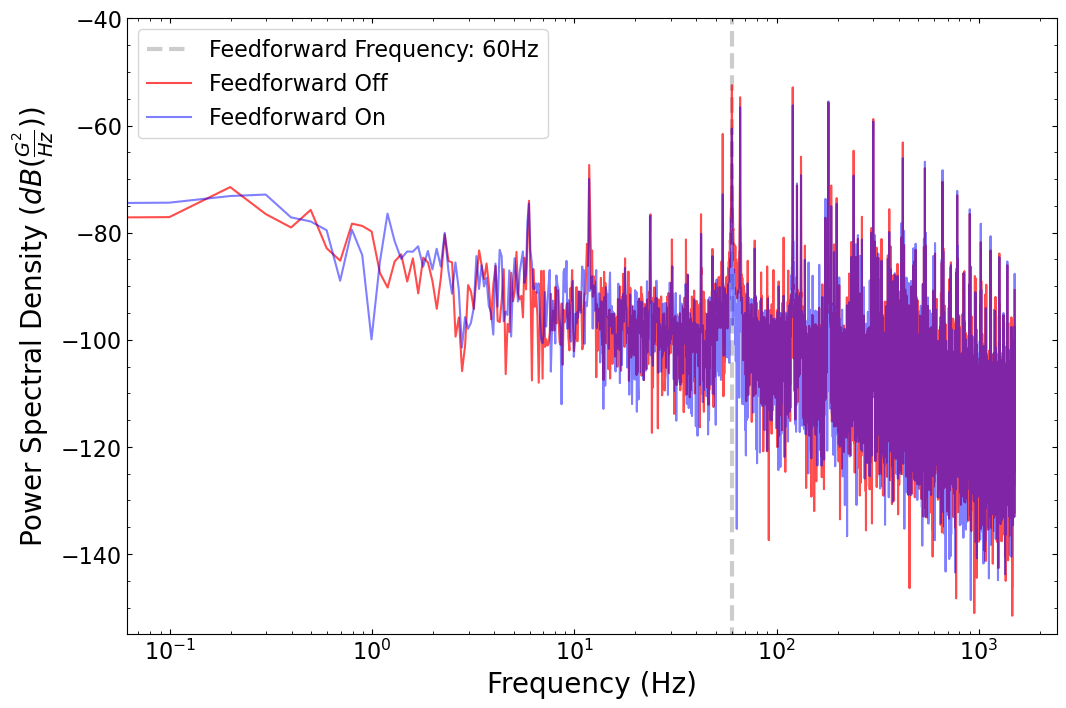

In [9]:
fig, ax = plt.subplots(1, figsize=(12, 8))

ax.vlines(60, -2000, 0, 'black', linestyle='--', lw=3, label=f'Feedforward Frequency: {60}Hz', alpha=0.2)
ax.plot(freq_1, power_1, label='Feedforward Off', c='red', alpha=0.7)
ax.plot(freq_2, power_2, label='Feedforward On', c='blue', alpha=0.5)

title = 'Feedforward'
#plt.suptitle(title, fontsize=20, y=0.95) 

ax.legend(loc='upper left', fontsize=16)

# Setting desired tick paramameters
ax.tick_params(axis='both', which='both', direction='in',
               top=True, right=True, labelsize=16)
ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
ax.yaxis.set_minor_locator(tck.AutoMinorLocator())

# Setting figure labels, log scale, display ranges
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_xscale('log')
ax.set(xlabel='Frequency (Hz)')
ax.set(ylabel=r'Power Spectral Density ($dB(\frac{G^{2}}{Hz}$))', ylim=(-155, -40))

# Save figure to designated filepath
save_path = r"C:\Users\wuhai\AMFS_figs\\" + title + '.png'
#plt.savefig(save_path, dpi=300)

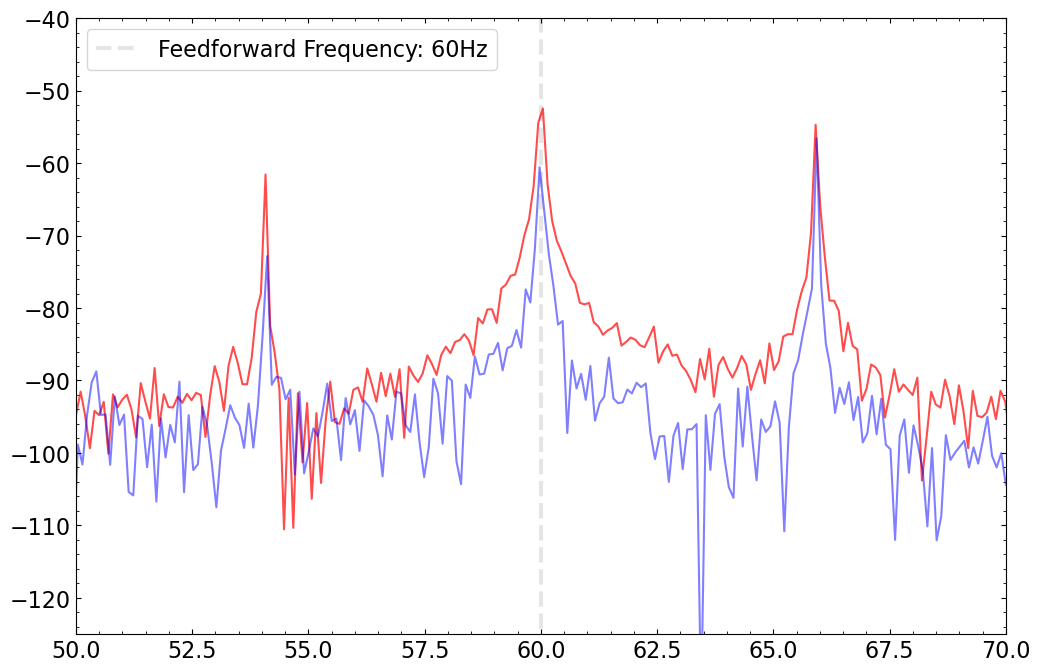

In [10]:
fig, ax = plt.subplots(1, figsize=(12, 8))

ax.vlines(60, -250, 0, 'black', linestyle='--', lw=3, label=f'Feedforward Frequency: {60}Hz', alpha=0.1)
ax.plot(freq_1, power_1, c='red', alpha=0.7)
ax.plot(freq_2, power_2,  c='blue', alpha=0.5)

title = 'Feedforward Enlarged'
#plt.suptitle(title, fontsize=20, y=0.95) 

ax.legend(loc='upper left', fontsize=16)

# Setting desired tick paramameters
ax.tick_params(axis='both', which='both', direction='in',
               top=True, right=True, labelsize=16)
ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
ax.yaxis.set_minor_locator(tck.AutoMinorLocator())

# Setting figure labels, log scale, display ranges
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
    
ax.set(xlim=(50, 70))
ax.set(ylim=(-125, -40))

# Save figure to designated filepath
save_path = r"C:\Users\wuhai\AMFS_figs\\" + title + '.png'
#plt.savefig(save_path, dpi=300, transparent=True)

# PI Feedback & Mains Electricity Feedforward

In [11]:
# filepaths
csv_pair = [r"C:\Users\wuhai\Downloads\PI_off_Feedforward_off_10s.csv",
            r"C:\Users\wuhai\Downloads\PI_on_Feedforward_on_10s_1.csv"]

times1, data1, times2, data2 = load_data(csv_pair, 'Feedback and Feedforward', 2)

# calculate data means and stds
data_1_mean, data_1_std = np.mean(data1), np.std(data1)
data_2_mean, data_2_std = np.mean(data2), np.std(data2)

# obtain frequency and power density arrays
freq_1, power_1 = get_power_density_spectrum(data1)
freq_2, power_2 = get_power_density_spectrum(data2)

# Obtain area ratios
cutoff_f = 850
area_1, area_2 = integrate_fft(freq_1, power_1, cutoff_f), integrate_fft(freq_2, power_2, cutoff_f)
print(area_1 / area_2)

# convert power density into dB
power_1 = 10 * np.log10(power_1)
power_2 = 10 * np.log10(power_2)

64.55388262346483


Mean: 3.1107 $\pm$ 0.0017 G
Mean: 3.0020 $\pm$ 0.0004 G


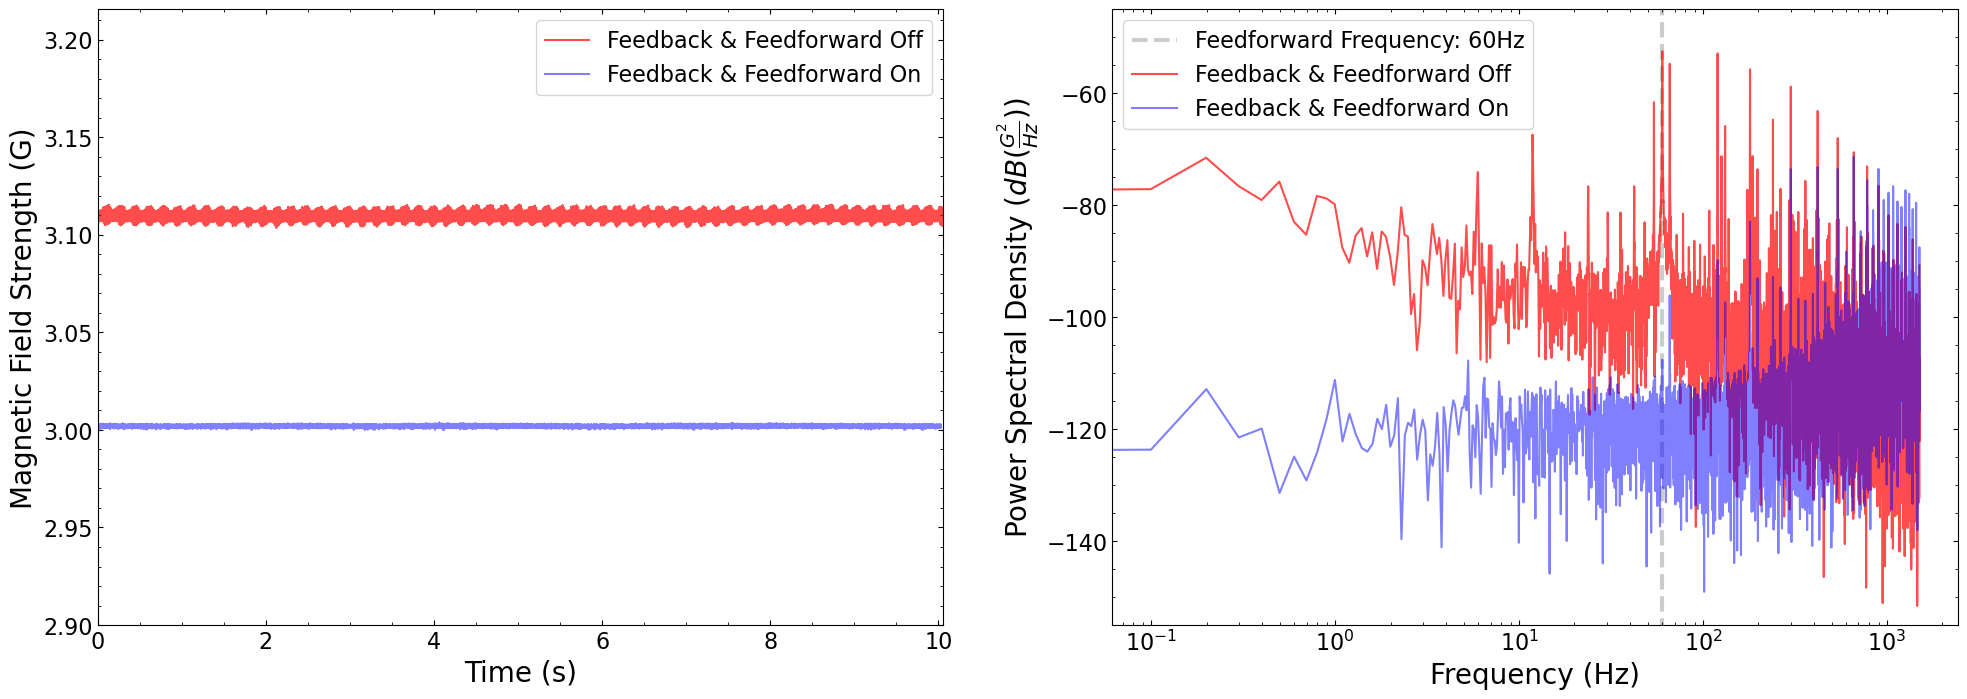

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(24, 8))

# Print data means and stds
data1_text = r'Mean: {:.4f} $\pm$ {:.4f} G'.format(data_1_mean, data_1_std)
data2_text = r'Mean: {:.4f} $\pm$ {:.4f} G'.format(data_2_mean, data_2_std)
print(data1_text)
print(data2_text)

ax[0].plot(times1, data1, label=f'Feedback & Feedforward Off', c='red', alpha=0.7)
ax[0].plot(times2, data2, label=f'Feedback & Feedforward On', c='blue', alpha=0.5)

ax[1].vlines(60, -250, 20, 'black', linestyle='--', lw=3, label=f'Feedforward Frequency: 60Hz', alpha=0.2)
#ax[1].vlines(60, -140, 0, 'orange', linestyle='--', lw=3, label=f'Feedforward Frequency: 60Hz', alpha=0.5)
ax[1].plot(freq_1, power_1, label='Feedback & Feedforward Off', c='red', alpha=0.7)
ax[1].plot(freq_2, power_2, label='Feedback & Feedforward On', c='blue', alpha=0.5)

title = 'Feedback and Feedforward'
#plt.suptitle(title, fontsize=20, y=0.95) 

# Setting figure display ranges
time_min, time_max = np.min([np.min(times1), np.min(times2)]), np.max([np.max(times1), np.max(times2)])
data1_min, data1_max = np.min([np.min(data1), np.min(data2)]), np.max([np.max(data1), np.max(data2)])
ax[0].set(ylim=(data1_min-0.1, data1_max+0.1))

ax[0].legend(loc='upper right', fontsize=16)
ax[0].set(xlabel='Time (s)', ylabel='Magnetic Field Strength (G)', xlim=(time_min, time_max))

# Setting desired tick paramameters
ax[0].tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=16)
ax[0].xaxis.set_minor_locator(tck.AutoMinorLocator())
ax[0].yaxis.set_minor_locator(tck.AutoMinorLocator())

# Setting label
ax[0].xaxis.label.set_size(20)
ax[0].yaxis.label.set_size(20)

for i in [1]:
    ax[i].legend(loc='upper left', fontsize=16)
    ax[i].tick_params(axis='both', which='both', direction='in',
                      top=True, right=True, labelsize=16)
    ax[i].xaxis.set_minor_locator(tck.AutoMinorLocator())
    ax[i].yaxis.set_minor_locator(tck.AutoMinorLocator())
    ax[i].xaxis.label.set_size(20)
    ax[i].yaxis.label.set_size(20)
    
# Setting label and log scale
ax[1].set_xscale('log')
ax[1].set(xlabel='Frequency (Hz)')
ax[1].set(ylabel=r'Power Spectral Density ($dB(\frac{G^{2}}{Hz}$))', ylim=(-155, -45))

# Save figure to designated filepath
save_path = r"C:\Users\wuhai\AMFS_figs\\" + title + '.png'
#plt.savefig(save_path, dpi=300)

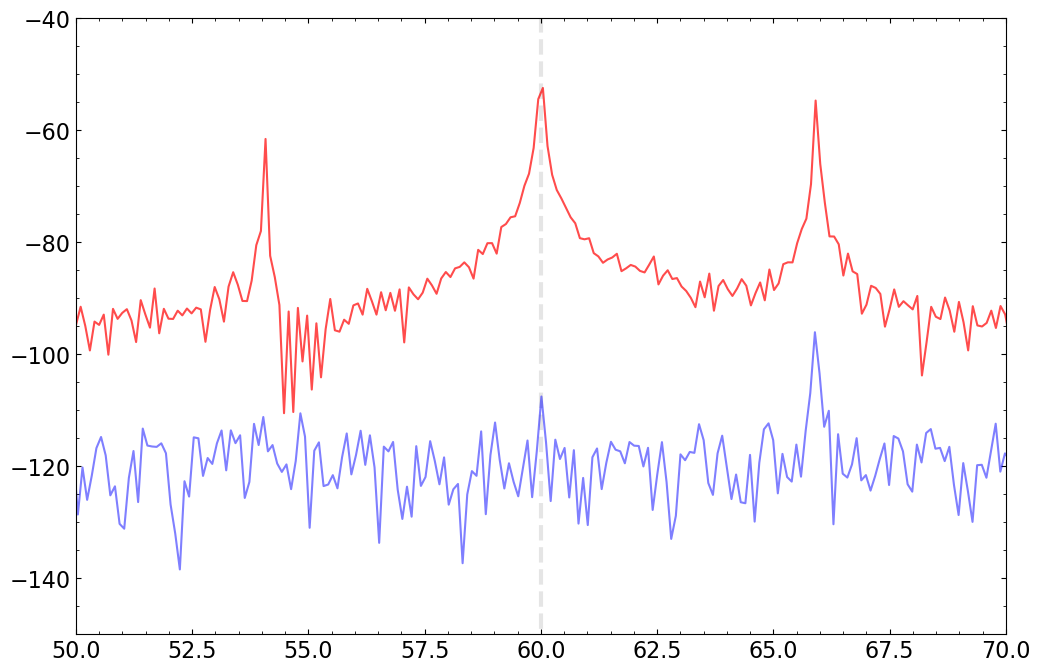

In [13]:
fig, ax = plt.subplots(1, figsize=(12, 8))

ax.vlines(60, -200, 0, 'black', linestyle='--', lw=3, label=f'Feedforward Frequency: {60}Hz', alpha=0.1)
ax.plot(freq_1, power_1, label='Feedback & Feedforward Off', c='red', alpha=0.7)
ax.plot(freq_2, power_2, label='Feedback & Feedforward On', c='blue', alpha=0.5)

title = 'Feedback & Feedforward Enlarged'
#plt.suptitle(title, fontsize=20, y=0.95) 

# Setting desired tick paramameters
#ax.legend(loc='upper left', fontsize=16)
ax.tick_params(axis='both', which='both', direction='in',
               top=True, right=True, labelsize=16)
ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
ax.yaxis.set_minor_locator(tck.AutoMinorLocator())

# Setting label
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)

# Setting figure display ranges
ax.set(xlim=(50, 70))
ax.set(ylim=(-150, -40))

# Save figure to designated filepath
save_path = r"C:\Users\wuhai\AMFS_figs\\" + title + '.png'
#plt.savefig(save_path, dpi=300, transparent=False)

# Permanent Magnets

In [14]:
# filepaths
csv_pair = [r"C:\Users\wuhai\Downloads\MokuPIDControllerData_20230501_172729_pidoff_two_magnets.csv",
            r"C:\Users\wuhai\Downloads\MokuPIDControllerData_20230501_172638_pidon_two_magnets.csv"]

times1, data1, times2, data2 = load_data(csv_pair, 'Feedback and Feedforward', 1)

# calculate data means and stds
data_1_mean, data_1_std = np.mean(data1), np.std(data1)
data_2_mean, data_2_std = np.mean(data2), np.std(data2)

# obtain frequency and power density arrays
freq_1, power_1 = get_power_density_spectrum(data1)
freq_2, power_2 = get_power_density_spectrum(data2)

# convert power density into dB
power_1 = 10 * np.log10(power_1)
power_2 = 10 * np.log10(power_2)

Mean: 3.0427 $\pm$ 0.1623 V
Mean: 2.9553 $\pm$ 0.0037 V


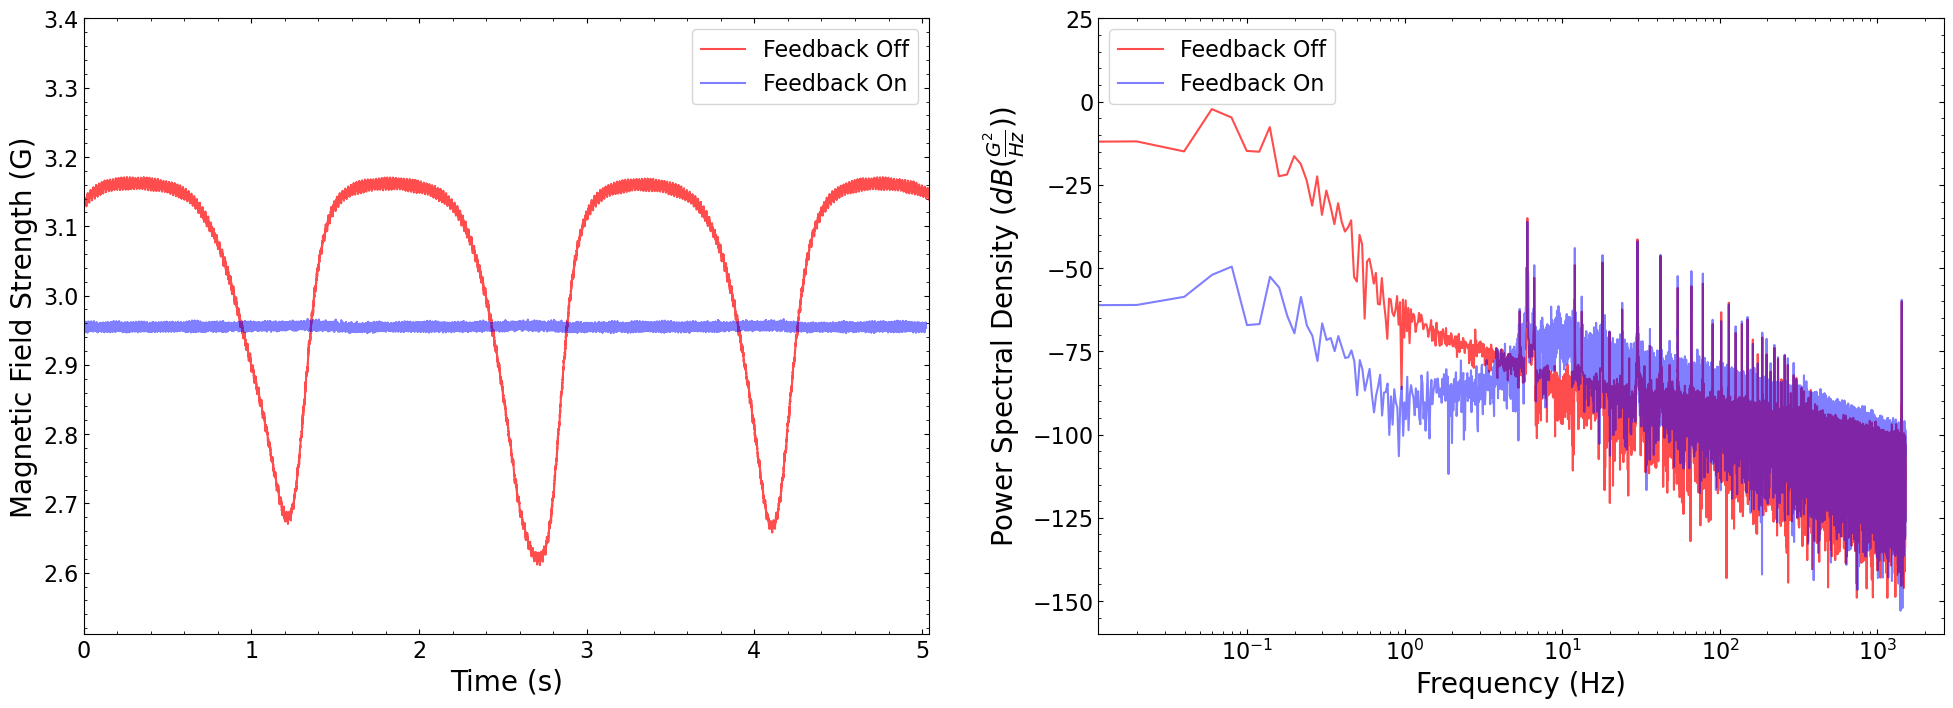

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(24, 8))

# Print data means and stds
data1_text = r'Mean: {:.4f} $\pm$ {:.4f} V'.format(data_1_mean, data_1_std)
data2_text = r'Mean: {:.4f} $\pm$ {:.4f} V'.format(data_2_mean, data_2_std)
print(data1_text)
print(data2_text)

ax[0].plot(times1, data1, label=f'Feedback Off', c='red', alpha=0.7)
ax[0].plot(times2, data2, label=f'Feedback On', c='blue', alpha=0.5)

#ax[1].vlines(60, -140, 0, 'orange', linestyle='--', lw=3, label=f'Feedforward Frequency: 60Hz', alpha=0.5)
ax[1].plot(freq_1, power_1, label='Feedback Off', c='red', alpha=0.7)
ax[1].plot(freq_2, power_2, label='Feedback On', c='blue', alpha=0.5)

title = 'Permanent Magnets Demo'
#plt.suptitle(title, fontsize=20, y=0.95) 

# Setting figure display ranges
time_min, time_max = np.min([np.min(times1), np.min(times2)]), np.max([np.max(times1), np.max(times2)])
data1_min, data1_max = np.min([np.min(data1), np.min(data2)]), np.max([np.max(data1), np.max(data2)])
ax[0].set(ylim=(data1_min-0.1, 3.4))

ax[0].legend(loc='upper right', fontsize=16)
ax[0].set(xlabel='Time (s)', ylabel='Magnetic Field Strength (G)', xlim=(time_min, time_max))

# Setting desired tick paramameters
ax[0].tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=16)
ax[0].xaxis.set_minor_locator(tck.AutoMinorLocator())
ax[0].yaxis.set_minor_locator(tck.AutoMinorLocator())

# Setting label
ax[0].xaxis.label.set_size(20)
ax[0].yaxis.label.set_size(20)

for i in [1]:
    ax[i].legend(loc='upper left', fontsize=16)
    ax[i].tick_params(axis='both', which='both', direction='in',
                      top=True, right=True, labelsize=16)
    ax[i].xaxis.set_minor_locator(tck.AutoMinorLocator())
    ax[i].yaxis.set_minor_locator(tck.AutoMinorLocator())
    ax[i].xaxis.label.set_size(20)
    ax[i].yaxis.label.set_size(20)
    
# Setting label and log scale
ax[1].set_xscale('log')
ax[1].set(xlabel='Frequency (Hz)')
ax[1].set(ylabel=r'Power Spectral Density ($dB(\frac{G^{2}}{Hz}$))', ylim=(-160, 25))

# Save figure to designated filepath
save_path = r"C:\Users\wuhai\AMFS_figs\\" + title + '.png'
#plt.savefig(save_path, dpi=300)

# Magnetic Field Drift

In [17]:
# filepaths
csv_pair = [r"C:\Users\wuhai\Downloads\BField_Noise_3600_1.csv",
            r"C:\Users\wuhai\Downloads\PI_off_Feedforward_off_10s.csv"]

times1, data1, times2, data2 = load_data(csv_pair, 'Feedback and Feedforward', 1)

# calculate data means and stds
data_1_mean, data_1_std = np.mean(data1), np.std(data1)
data_2_mean, data_2_std = np.mean(data2), np.std(data2)

# obtain frequency and power density arrays
freq_1, power_1 = get_power_density_spectrum(data1)
freq_2, power_2 = get_power_density_spectrum(data2)

# convert power density into dB
power_1 = 10 * np.log10(power_1)
power_2 = 10 * np.log10(power_2)

Mean: 3.2300 $\pm$ 0.0025 V


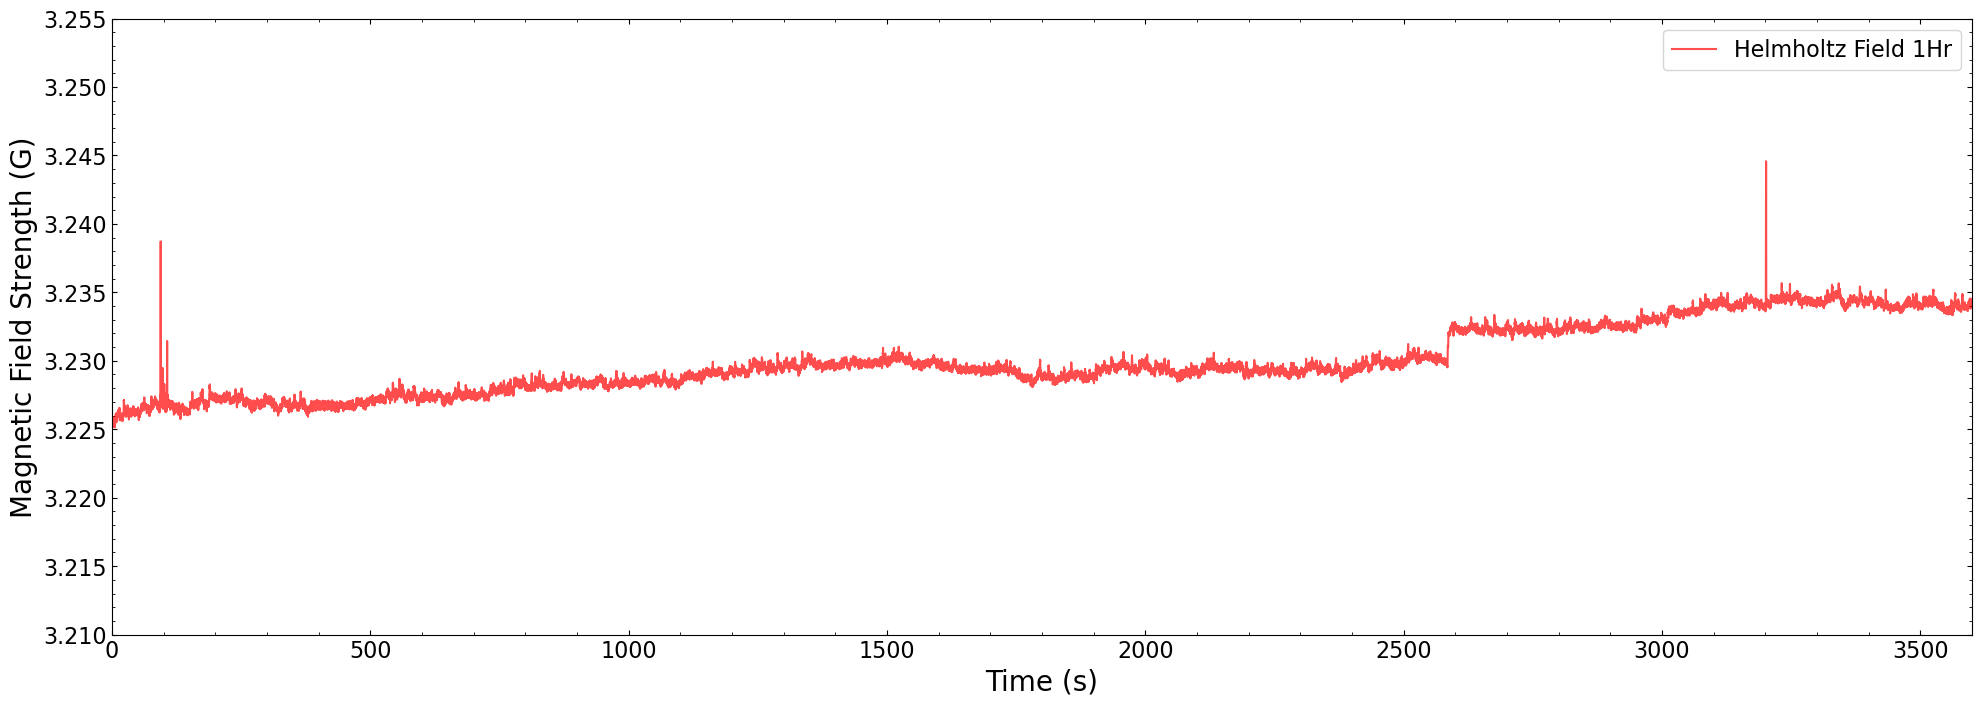

In [18]:
fig, ax = plt.subplots(1, figsize=(24, 8))

# Print data means and stds
data1_text = r'Mean: {:.4f} $\pm$ {:.4f} V'.format(-data_1_mean, data_1_std)
print(data1_text)

ax.plot(times1, -data1, label=f'Helmholtz Field 1Hr', c='red', alpha=0.7)

#ax[1].vlines(60, -140, 0, 'orange', linestyle='--', lw=3, label=f'Feedforward Frequency: 60Hz', alpha=0.5)

title = 'Helmholtz Field Drift 1Hr'
#plt.suptitle(title, fontsize=20, y=0.95) 

# Setting figure display ranges
time_min, time_max = np.min([np.min(times1), np.min(times2)]), np.max([np.max(times1), np.max(times2)])
data1_min, data1_max = np.min([np.min(data1), np.min(data2)]), np.max([np.max(data1), np.max(data2)])
ax.set(ylim=(3.21, 3.255))

ax.legend(loc='upper right', fontsize=16)
ax.set(xlabel='Time (s)', ylabel='Magnetic Field Strength (G)', xlim=(time_min, time_max))

# Setting desired tick paramameters
ax.tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=16)
ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
ax.yaxis.set_minor_locator(tck.AutoMinorLocator())

# Setting label
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)

# Save figure to designated filepath
save_path = r"C:\Users\wuhai\AMFS_figs\\" + title + '.png'
#plt.savefig(save_path, dpi=300)

Mean: 3.1107 $\pm$ 0.0017 V


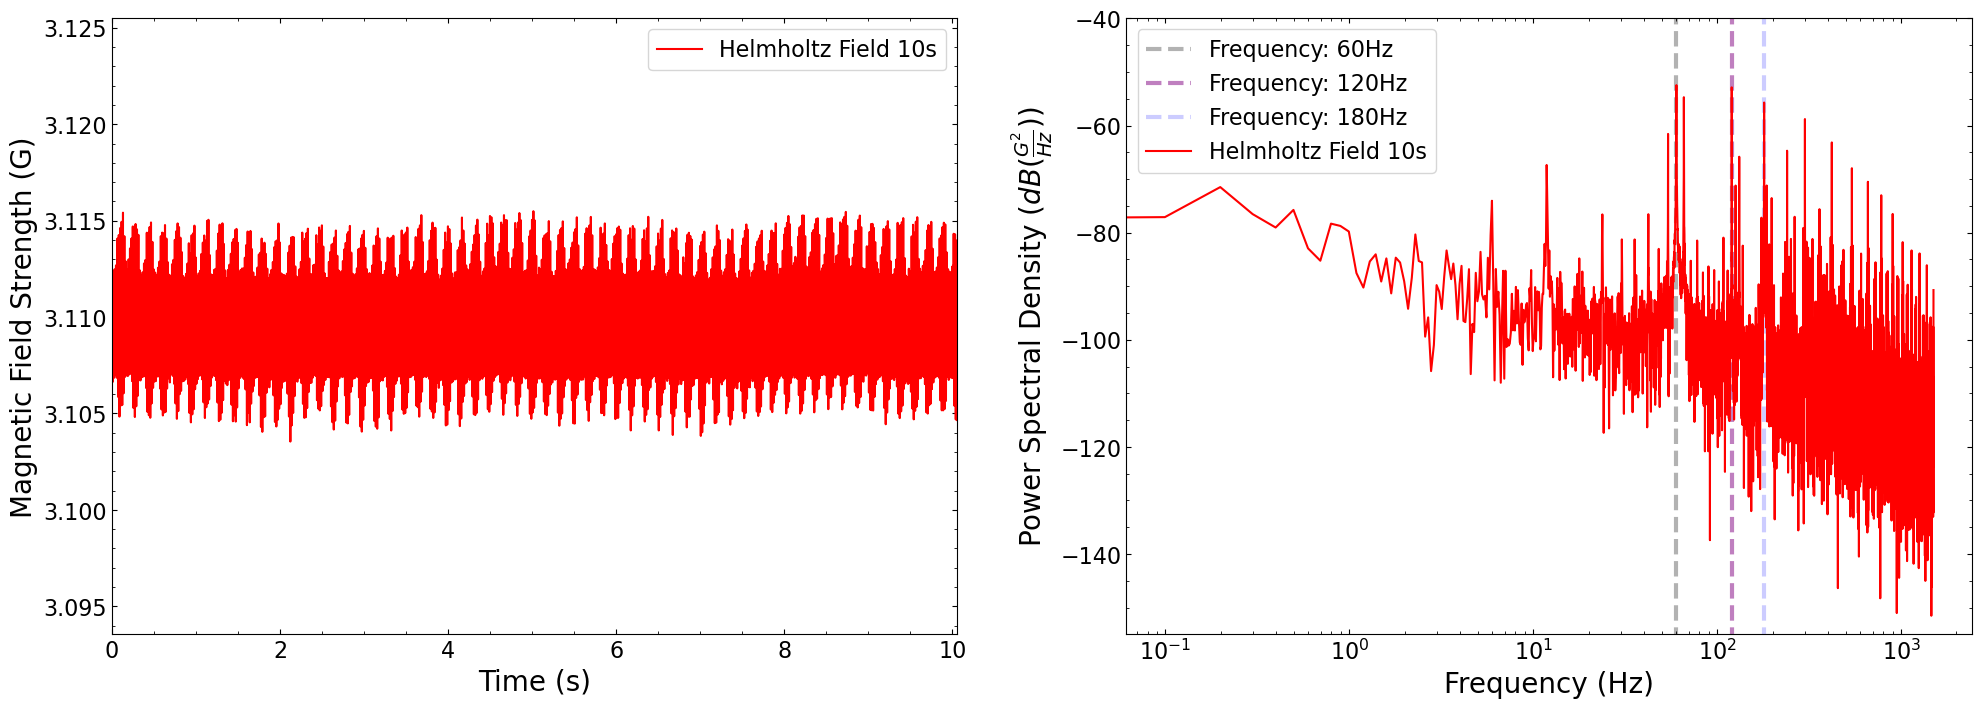

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(24, 8))

# Print data means and stds
data2_text = r'Mean: {:.4f} $\pm$ {:.4f} V'.format(data_2_mean, data_2_std)
print(data2_text)

ax[0].plot(times2, data2, label=f'Helmholtz Field 10s', c='red', alpha=1)

#ax[1].vlines(60, -140, 0, 'orange', linestyle='--', lw=3, label=f'Feedforward Frequency: 60Hz', alpha=0.5)
ax[1].vlines(60, -200, 40, 'black', linestyle='--', lw=3, label=f'Frequency: {60}Hz', alpha=0.3)
ax[1].vlines(120, -200, 40, 'purple', linestyle='--', lw=3, label=f'Frequency: {120}Hz', alpha=0.5)
ax[1].vlines(180, -200, 40, 'blue', linestyle='--', lw=3, label=f'Frequency: {180}Hz', alpha=0.2)
ax[1].plot(freq_2, power_2, label='Helmholtz Field 10s', c='red', alpha=1)

title = 'Helmholtz Field Drift 10s'
#plt.suptitle(title, fontsize=20, y=0.95) 

# Setting figure display ranges
time_min, time_max = np.min(times2), np.max(times2)
data2_min, data2_max = np.min(data2), np.max(data2)
ax[0].set(ylim=(data2_min-0.01, data2_max+0.01))

ax[0].legend(loc='upper right', fontsize=16)
ax[0].set(xlabel='Time (s)', ylabel='Magnetic Field Strength (G)', xlim=(time_min, time_max))

# Setting desired tick paramameters
ax[0].tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=16)
ax[0].xaxis.set_minor_locator(tck.AutoMinorLocator())
ax[0].yaxis.set_minor_locator(tck.AutoMinorLocator())

# Setting label
ax[0].xaxis.label.set_size(20)
ax[0].yaxis.label.set_size(20)

for i in [1]:
    ax[i].legend(loc='upper left', fontsize=16)
    # Setting desired tick paramameters
    ax[i].tick_params(axis='both', which='both', direction='in',
                      top=True, right=True, labelsize=16)
    ax[i].xaxis.set_minor_locator(tck.AutoMinorLocator())
    ax[i].yaxis.set_minor_locator(tck.AutoMinorLocator())
    ax[i].xaxis.label.set_size(20)
    ax[i].yaxis.label.set_size(20)

# Setting log scale and label
ax[1].set_xscale('log')
ax[1].set(xlabel='Frequency (Hz)')
ax[1].set(ylabel=r'Power Spectral Density ($dB(\frac{G^{2}}{Hz}$))', ylim=(-155, -40))

# Save figure to designated filepath
save_path = r"C:\Users\wuhai\AMFS_figs\\" + title + '.png'
#plt.savefig(save_path, dpi=300)